In [1]:
## CE 295 - Energy Systems and Control
#   HW 3 : Optimal Economic Dispatch in Distribution Feeders with Renewables
#   Oski Bear, SID 18681868
#   Prof. Arnold
#   Updated 11/05/2021

# BEAR_OSKI_HW3.ipynb

import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *
%matplotlib inline
import pandas as pd

In [2]:
## 13 Node IEEE Test Feeder Parameters

### Node (aka Bus) Data
# l_j^P: Active power consumption [MW]
l_P = np.array([0,0.2,0,0.4,0.17,0.23,1.155,0,0.17,0.843,0,0.17,0.128])

# l_j^Q: Reactive power consumption [MVAr]
l_Q = np.array([0,0.116,0,0.29,0.125,0.132,0.66,0,0.151,0.462,0,0.08,0.086 ])

# l_j^S: Apparent power consumption [MVA]
l_S = np.sqrt(l_P**2 + l_Q**2)

# s_j,max: Maximal generating power [MW]
s_max = np.array([5,0,0,3,0,0,0,0,0,3,0,0,0])

# c_j: Marginal generation cost [USD/MW]
c = np.array([100,0,0,150,0,0,0,0,0,50,0,0,0])

# V_min, V_max: Minimum and maximum nodal voltages [V]
v_min = 0.95
v_max = 1.05

### Edge (aka Line) Data
# r_ij: Resistance [p.u.]
r = np.array([[0, 0.007547918, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0.0041, 0, 0.007239685, 0, 0.007547918, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0.004343811, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0.003773959, 0, 0, 0.004322245, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00434686, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004343157, 0.01169764],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# x_ij: Reactance [p.u.]
x = np.array([[0, 0.022173236, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0.0064, 0, 0.007336076, 0, 0.022173236, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0.004401645, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0.011086618, 0, 0, 0.004433667, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.002430473, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004402952, 0.004490848],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# I_max_ij: Maximal line current [p.u.]
I_max = np.array([[0, 3.0441, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1.4178, 0, 0.9591, 0, 3.0441, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 3.1275, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0.9591, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 3.0441, 3.1275, 0, 0.9591, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1.37193, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9591, 1.2927],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# \rho(j): Parent node of node j
rho = np.array([0, 0, 1, 2, 1, 4, 1, 6, 6, 8, 6, 10, 10])

# A_ij: Adjacency matrix; A_ij = 1 if i is parent of j
A = np.zeros((13, 13))
j = 0
for i in rho:
        A[i,j] = 1
        j+=1

### Set Data
# List of node indices
j_idx = np.arange(13)


In [34]:
A

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

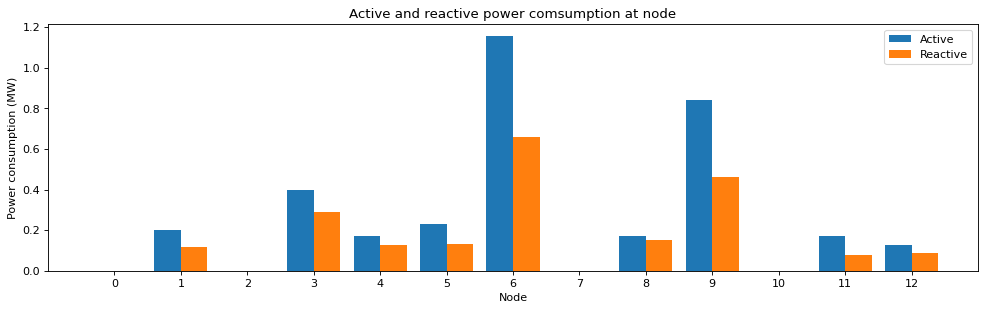

In [3]:
## Problem 1

# Plot active and reactive power consumption
plt.figure(num=1, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
 
# create plot
plt.bar(j_idx-0.2, l_P, width=0.4, label='Active')
plt.bar(j_idx+0.2, l_Q, width=0.4, label='Reactive')
plt.xticks(j_idx)
plt.xlim([-1, 13])
plt.legend()
plt.xlabel('Node')
plt.ylabel('Power consumption (MW)')
plt.title("Active and reactive power comsumption at node")

plt.show()

In [4]:
## Problem 2

# Assumptions:
#   - Disregard the entire network diagram
#   - Balance supply and demand, without any network considerations
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)

# Define objective function
objective = Minimize(sum(multiply(c,s)))

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max ]

# Balance power generation with power consumption
constraints += [sum(p) == sum(l_P), sum(q) == sum(l_Q) ]

# Loop over each node
for jj in j_idx:
    
    # Non-negative power generation
    constraints += [p[jj] >= 0, q[jj] >= 0]
    # Compute apparent power from active & reactive power
    constraints += [norm(hstack((p[jj],q[jj]))) <= s[jj]]

# Define problem and solve
prob2 = Problem(objective, constraints)
prob2.solve()

# Output Results
print("------------------- PROBLEM 2 --------------------")
print("--------------------------------------------------")
print(prob2.status)
print("Minimum Generating Cost : %4.2f"%(prob2.value),"USD")
print(" ")
print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MVAr | s_0 = %1.3f"%(s[0].value),"MVA")
print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MVAr | s_3 = %1.3f"%(s[3].value),"MVA")
print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MVAr | s_9 = %1.3f"%(s[9].value),"MVA")
print(" ")
print("Total active power   : %1.3f"%(np.sum(l_P)),"MW   consumed | %1.3f"%(np.sum(p.value)),"MW   generated")
print("Total reactive power : %1.3f"%(np.sum(l_Q)),"MVAr consumed | %1.3f"%(np.sum(q.value)),"MVAr generated")
print("Total apparent power : %1.3f"%(np.sum(l_S)),"MVA  consumed | %1.3f"%(np.sum(s.value)),"MVA  generated")

------------------- PROBLEM 2 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 255.36 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.901 MW | q_0 = 0.546 MVAr | s_0 = 1.054 MVA
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MVAr | s_3 = 0.000 MVA
Node 9 [Solar] Gen Power : p_9 = 2.565 MW | q_9 = 1.556 MVAr | s_9 = 3.000 MVA
 
Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.054 MVA  generated


In [8]:
print('Dual variable mu_s:\n', constraints[0].dual_value)

Dual variable mu_s:
 [2.71965094e-09 3.05397381e+02 3.05397381e+02 2.70575808e-09
 3.05397381e+02 3.05397381e+02 3.05397381e+02 3.05397381e+02
 3.05397381e+02 5.00000000e+01 3.05397381e+02 3.05397381e+02
 3.05397381e+02]


In [9]:
## Problem 3

# Assumptions:
#   - Disregard L_ij, the squared magnitude of complex line current
#   - Disregard nodal voltage equation
#   - Disregard nodal voltage limits
#   - Disregard maximum line current
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13) #active gen
q = Variable(13) #reactive gen
s = Variable(13) #apparent gen
P = Variable((13,13)) #active power flowing TO j
Q = Variable((13,13)) #reactive power flowing TO j

# Define objective function
objective = Minimize(c @ s)

# Define constraints
# Apparent Power Limits
# constraints = [s <= s_max]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
               Q[0,0] == 0]


s_max_pro = np.hstack([s_max[:9], s_max[9]+1, np.zeros(3, dtype=int)])
constraints = [s <= (s_max_pro)]

# Loop over each node

for jj in j_idx:
    
    # Non-negative power generation and flows
    constraints += [p[jj] >= 0]
    constraints += [q[jj] >= 0]

    # Parent node, i = \rho(j)
    i = rho[jj]
    # Line Power Flows
    constraints += [P[i,jj] == l_P[jj] - p[jj] + sum(multiply(A[jj,:],P[jj,:])),
                    Q[i,jj] == l_Q[jj] - q[jj] + sum(multiply(A[jj,:],Q[jj,:]))]

    # Compute apparent power from active & reactive power
    constraints += [norm(hstack((p[jj],q[jj]))) <= s[jj]]



# Define problem and solve
prob3 = Problem(objective, constraints)
prob3.solve()

# Output Results
print("------------------- PROBLEM 3 --------------------")
print("--------------------------------------------------")
print(prob3.status)
print("Minimum Generating Cost : %4.2f"%(prob3.value),"USD")
print(" ")
print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MVAr | s_0 = %1.3f"%(s[0].value),"MVA")
print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MVAr | s_3 = %1.3f"%(s[3].value),"MVA")
print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MVAr | s_9 = %1.3f"%(s[9].value),"MVA")
print(" ")
print("Total active power   : %1.3f"%(np.sum(l_P)),"MW   consumed | %1.3f"%(np.sum(p.value)),"MW   generated")
print("Total reactive power : %1.3f"%(np.sum(l_Q)),"MVAr consumed | %1.3f"%(np.sum(q.value)),"MVAr generated")
print("Total apparent power : %1.3f"%(np.sum(l_S)),"MVA  consumed | %1.3f"%(np.sum(s.value)),"MVA  generated")

------------------- PROBLEM 3 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 205.36 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.046 MW | q_0 = 0.028 MVAr | s_0 = 0.054 MVA
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MVAr | s_3 = 0.000 MVA
Node 9 [Solar] Gen Power : p_9 = 3.420 MW | q_9 = 2.074 MVAr | s_9 = 4.000 MVA
 
Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.054 MVA  generated


In [21]:
## Problem 4

# Assumptions:
#   - Add back all previously disregarded terms and constraints
#   - Relax squared line current equation into inequality
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13) #active gen
q = Variable(13) #reactive gen
s = Variable(13) #apparent gen
P = Variable((13,13)) #active power flowing TO j
Q = Variable((13,13)) #reactive power flowing TO j
V = Variable(13)
L = Variable((13,13))

# Define objective function
objective = Minimize(c.T @ s)

v_min = 0.95
v_max = 1.05
# Define constraints
# Apparent Power Limits
constraints = [s <= (s_max)]

# Nodal voltage limits
constraints += [V >= v_min**2]
constraints += [V <= v_max**2]

# Squared line current limits
constraints += [L <= I_max**2]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
                Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Non-negative power generation and flows
    constraints += [p[jj] >= 0]
    constraints += [q[jj] >= 0]

    # Parent node, i = \rho(j)
    i = rho[jj]
    
    # Line Power Flows
    constraints += [P[i,jj] == l_P[jj] - p[jj] + r[i,jj]*L[i,jj] + sum(multiply(A[jj,:],P[jj,:]))]
    constraints += [Q[i,jj] == l_Q[jj] - q[jj] + x[i,jj]*L[i,jj] + sum(multiply(A[jj,:],Q[jj,:]))]


    # Nodal voltage
    constraints += [V[jj] == V[i] + (r[i,jj]**2 + x[i,jj]**2)*L[i,jj] - 2*(r[i,jj]*P[i,jj] + x[i,jj]*Q[i,jj])]
    
    # Squared current magnitude on lines
    constraints += [L[i,jj] >= quad_over_lin(P[i,jj], V[jj]) + quad_over_lin(Q[i,jj], V[jj])]
    
    # Compute apparent power from active & reactive power
    constraints += [norm(hstack((p[jj],q[jj])), 2) <= s[jj]]


    

# Define problem and solve
prob4 = Problem(objective, constraints)
prob4.solve()

# Output Results
print("------------------- PROBLEM 4 --------------------")
print("--------------------------------------------------")
print(prob4.status)
print("Minimum Generating Cost : %4.2f"%(prob4.value),"USD")
print(" ")
print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MVAr | s_0 = %1.3f"%(s[0].value),"MVA")
print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MVAr | s_3 = %1.3f"%(s[3].value),"MVA")
print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MVAr | s_9 = %1.3f"%(s[9].value),"MVA")
print(" ")
print("Total active power   : %1.3f"%(np.sum(l_P)),"MW   consumed | %1.3f"%(np.sum(p.value)),"MW   generated")
print("Total reactive power : %1.3f"%(np.sum(l_Q)),"MVAr consumed | %1.3f"%(np.sum(q.value)),"MVAr generated")
print("Total apparent power : %1.3f"%(np.sum(l_S)),"MVA  consumed | %1.3f"%(np.sum(s.value)),"MVA  generated")
print(" ")
for jj in j_idx:
    print("Node %2.0f"%(jj), "Voltage : %1.3f"%((V[jj].value)**0.5), "p.u. || ", "mu_vmin: %.3E"%(constraints[1].dual_value[jj]), " | mu_vmax: %.3E"%(constraints[2].dual_value[jj]))

------------------- PROBLEM 4 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 299.69 USD
 
Node 0 [Grid]  Gen Power : p_0 = 1.568 MW | q_0 = 0.985 MVAr | s_0 = 1.852 MVA
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MVAr | s_3 = 0.000 MVA
Node 9 [Solar] Gen Power : p_9 = 1.941 MW | q_9 = 1.216 MVAr | s_9 = 2.290 MVA
 
Total active power   : 3.466 MW   consumed | 3.509 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.201 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.142 MVA  generated
 
Node  0 Voltage : 1.000 p.u. ||  mu_vmin: 1.784E-08  | mu_vmax: 1.697E-08
Node  1 Voltage : 0.967 p.u. ||  mu_vmin: 5.390E-08  | mu_vmax: 1.041E-08
Node  2 Voltage : 0.963 p.u. ||  mu_vmin: 6.907E-08  | mu_vmax: 1.000E-08
Node  3 Voltage : 0.963 p.u. ||  mu_vmin: 6.907E-08  | mu_vmax: 1.000E-08
Node  4 Voltage : 0.962 p.u. ||  mu_vmin: 7.704E-08  | mu_vmax: 9.849E-09
Node  5 Voltage : 0.960 p.u. ||  mu_vmin: 

In [23]:
# Voltage constraint
vol_con = 1
vol_con_act = [(jj, constraints[vol_con].dual_value[jj]) for jj in j_idx if constraints[vol_con].dual_value[jj] > 0.0001]
print("active voltage constraints:", vol_con_act)

# Current constraint
cur_con = 3
cur_con_act = [((int(rho[jj]), jj), constraints[cur_con].dual_value[int(rho[jj]), jj]) for jj in j_idx if constraints[cur_con].dual_value[int(rho[jj]), jj] > 0.0001]
print("active current constraints:", cur_con_act)

active voltage constraints: []
active current constraints: [((0, 0), 125.40983773127309), ((8, 9), 22.518357854879877)]


In [22]:
print('constraint (8):\n', constraints[1].dual_value, '\n', constraints[2].dual_value)
print('\nconstraint (9):\n', constraints[3].dual_value)

constraint (8):
 [1.78359325e-08 5.39038761e-08 6.90700010e-08 6.90702361e-08
 7.70355522e-08 8.97476237e-08 1.28959259e-07 1.28987548e-07
 1.28960206e-07 6.48157401e-08 1.85754083e-07 2.43534942e-07
 3.14931531e-07] 
 [1.69679248e-08 1.04123409e-08 1.00020308e-08 1.00020226e-08
 9.84930234e-09 9.67674695e-09 9.39455343e-09 9.39434411e-09
 9.39454225e-09 1.01190883e-08 9.19204438e-09 9.08683965e-09
 9.01132206e-09]

constraint (9):
 [[1.25409838e+02 3.42134684e-10 1.56655448e-09 1.56655448e-09
  1.56655448e-09 1.56655448e-09 1.56655448e-09 1.56655448e-09
  1.56655448e-09 1.56655448e-09 1.56655448e-09 1.56655448e-09
  1.56655448e-09]
 [1.56655448e-09 1.56655448e-09 9.82625751e-10 1.56655448e-09
  2.74081930e-09 1.56655448e-09 2.32925510e-10 1.56655448e-09
  1.56655448e-09 1.56655448e-09 1.56655448e-09 1.56655448e-09
  1.56655448e-09]
 [1.56655448e-09 1.56655448e-09 1.56655448e-09 1.31847892e-09
  1.56655448e-09 1.56655448e-09 1.56655448e-09 1.56655448e-09
  1.56655448e-09 1.56655448e-09

In [20]:
# Problem 5
# Assumptions:
#   - Assume solar generator at node 9 has uncertain power capacity
#   - Goal is to minimize generation costs, given by c^T s, in face of uncertainty

# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)
P = Variable((13, 13))
Q = Variable((13, 13))
V = Variable(13)
L = Variable((13, 13))
sig = Variable(2)

# Define objective function
objective = Minimize(c.T @ s)

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]

# Nodal voltage limits
constraints += [V >= (v_min**2), V <= (v_max**2)]

# Squared line current limits
constraints += [L <= (I_max**2)]

# Solar panels percentage output
constraints += [sig >= 0, sig <= 1]

# Boundary condition for power line flows
constraints += [P[0,0] == 0, Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Non-negative power generation and flows
    constraints += [p[jj] >= 0]
    constraints += [q[jj] >= 0]
    
    # Parent node, i = \rho(j)
    i = int(rho[jj])
    
    # Line Power Flows
    constraints += [P[i,jj] == (l_P[jj] - p[jj]) + (r[i,jj] * L[i,jj]) + (A[jj,:] @ P[jj,:])]
    constraints += [Q[i,jj] == (l_Q[jj] - q[jj]) + (x[i,jj] * L[i,jj]) + (A[jj,:] @ Q[jj,:])]

    # Nodal voltage
    constraints += [V[jj] == V[i] + (((r[i,jj]**2) + (x[i,jj]**2))*L[i,jj]) - (2*((r[i,jj]*P[i,jj]) + (x[i,jj]*Q[i,jj])))]
    
    # Squared current magnitude on lines
    constraints += [L[i,jj] >= quad_over_lin(vstack([P[i,jj], Q[i,jj]]), V[jj])]
   
    # Compute apparent power from active & reactive power
    constraints += [s[jj] >= norm(vstack([p[jj], q[jj]]))]    

# Solar panel constraints
a_bar = np.array([-1.25, -1.25, 1])
E = np.diag([0.25, 0.25, 0])
y = vstack((sig[0], sig[1], s[9]))
b = 0
constraints += [a_bar.T@y + norm(E.T@y) <= 0]
    
# Define problem and solve
prob4 = Problem(objective, constraints)
prob4.solve()

# Output Results
print("------------------- PROBLEM 5 --------------------")
print("--------------------------------------------------")
print(prob4.status)
print("Minimum Generating Cost : %4.2f"%(prob4.value),"USD")
print(" ")
print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value))
print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value))
print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value))
print(" ")
print("Total active power   : %1.3f"%(np.sum(l_P)),"MW   consumed | %1.3f"%(np.sum(p.value)),"MW   generated")
print("Total reactive power : %1.3f"%(np.sum(l_Q)),"MVAr consumed | %1.3f"%(np.sum(q.value)),"MVAr generated")
print("Total apparent power : %1.3f"%(np.sum(l_S)),"MVA  consumed | %1.3f"%(np.sum(s.value)),"MVA  generated")
print(" ")
for jj in j_idx:
    print("Node %2.0f"%(jj), "Voltage : %1.3f"%((V[jj].value)**0.5), "p.u.")

------------------- PROBLEM 5 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 308.72 USD
 
Node 0 [Grid]  Gen Power : p_0 = 1.745 MW | q_0 = 1.006 MW | s_0 = 2.014
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = -0.000
Node 9 [Solar] Gen Power : p_9 = 1.770 MW | q_9 = 1.215 MW | s_9 = 2.146
 
Total active power   : 3.466 MW   consumed | 3.514 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.221 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.160 MVA  generated
 
Node  0 Voltage : 1.000 p.u.
Node  1 Voltage : 0.965 p.u.
Node  2 Voltage : 0.961 p.u.
Node  3 Voltage : 0.961 p.u.
Node  4 Voltage : 0.960 p.u.
Node  5 Voltage : 0.958 p.u.
Node  6 Voltage : 0.954 p.u.
Node  7 Voltage : 0.954 p.u.
Node  8 Voltage : 0.954 p.u.
Node  9 Voltage : 0.960 p.u.
Node 10 Voltage : 0.952 p.u.
Node 11 Voltage : 0.951 p.u.
Node 12 Voltage : 0.950 p.u.
